In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nprobust import lprobust, lpbwselect, kdrobust, kdbwselect
from did_had import DidHad


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [26]:
#%% ============================================================================
# Load data
# ==============================================================================

df = pd.read_csv("../data/fig2a-c.csv.gz")


# sum top_link
print("Summary of top_link (before collapse):")
print(df['top_link'].describe())

# collapse (mean) *_growth top_link, by(pid year)
growth_cols = [col for col in df.columns if col.endswith('_growth')]
collapse_cols = growth_cols + ['top_link']
df = df.groupby(['pid', 'year'])[collapse_cols].mean().reset_index()

# sum top_link
print("\nSummary of top_link (after collapse):")
print(df['top_link'].describe())

# sort pid year
df = df.sort_values(['pid', 'year']).reset_index(drop=True)

# bys pid: gen cid = _n == 1
df['cid'] = df.groupby('pid').cumcount() == 0

# count if top_link == 0 & cid == 1
n_zero = ((df['top_link'] == 0) & (df['cid'])).sum()
print(f"\ncount if top_link == 0 & cid == 1: {n_zero}")

# count if cid == 1
n_total = df['cid'].sum()
print(f"count if cid == 1: {n_total}")


Summary of top_link (before collapse):
count    1.231583e+06
mean     2.532964e+00
std      8.607478e-01
min      0.000000e+00
25%      1.998951e+00
50%      2.470954e+00
75%      3.003918e+00
max      8.786472e+00
Name: top_link, dtype: float64

Summary of top_link (after collapse):
count    47264.000000
mean         2.227384
std          0.997002
min          0.000000
25%          1.561070
50%          2.182269
75%          2.774179
max          8.786472
Name: top_link, dtype: float64

count if top_link == 0 & cid == 1: 12
count if cid == 1: 2954


Ratio 1: nan
Ratio 2: nan


/var/folders/gb/56xms55d53n734tnp7xq55bh0000gq/T/ipykernel_42706/1486104220.py:12: RuntimeWarning: invalid value encountered in scalar divide
  ratio1 = df_temp['top_link'].iloc[0] / (df_temp['top_link'].iloc[1] - df_temp['top_link'].iloc[0])
/var/folders/gb/56xms55d53n734tnp7xq55bh0000gq/T/ipykernel_42706/1486104220.py:16: RuntimeWarning: invalid value encountered in scalar divide
  ratio2 = df_temp['top_link'].iloc[0]**2 / (df_temp['top_link'].iloc[1]**2 - df_temp['top_link'].iloc[0]**2)


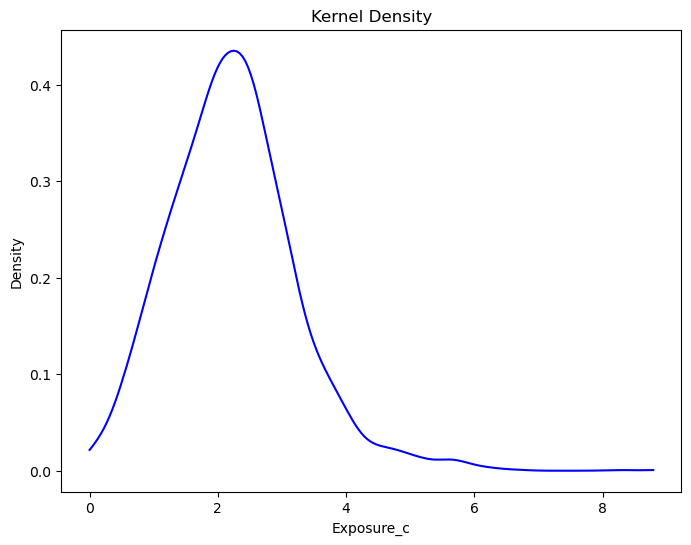

In [ ]:


# preserve
df_temp = df.copy()

# bys pid: keep if _n == 1
df_temp = df_temp.groupby('pid').first().reset_index()

# sort top_link
df_temp = df_temp.sort_values('top_link').reset_index(drop=True)

# noi di top_link[1]/(top_link[2] - top_link[1])
# Note: Stata uses 1-based indexing, Python uses 0-based
ratio1 = df_temp['top_link'].iloc[0] / (df_temp['top_link'].iloc[1] - df_temp['top_link'].iloc[0])
print(f"Ratio 1: {ratio1}")

# noi di top_link[1]^2/(top_link[2]^2 - top_link[1]^2)
ratio2 = df_temp['top_link'].iloc[0]**2 / (df_temp['top_link'].iloc[1]**2 - df_temp['top_link'].iloc[0]**2)
print(f"Ratio 2: {ratio2}")

# label var top_link "Exposure_c"
# (just for plot label)

# kdensity top_link
kde = gaussian_kde(df_temp['top_link'])
x_range = np.linspace(df_temp['top_link'].min(), df_temp['top_link'].max(), 200)

plt.figure(figsize=(8, 6))
plt.plot(x_range, kde(x_range), 'b-')
plt.xlabel('Exposure_c')
plt.ylabel('Density')
plt.title('Kernel Density')
plt.show()


# restore
# (df remains unchanged since we used df_temp)

In [ ]:
# Define outcome labels
outcome_labels = {
    'emp': 'Employment',
    'comp': 'Earnings',
    'wage': 'Earnings-per-worker'
}


# gen D = (year > 2001) * top_link
df['D'] = (df['year'] > 2001).astype(int) * df['top_link']
# stop

In [ ]:

model = DidHad(kernel="epa")
result = model.fit(
    df=df,
    outcome='emp_growth',
    group='pid',
    time='year',
    treatment='D',
    effects=11,
    placebo=4
)
result

DID-HAD Estimation Results
Number of groups: 2,954
Number of periods: 16
Adoption period (F): 2002
Kernel: epa
Bandwidth selection: mse-dpi
Confidence level: 95%
Dynamic effects: False

---------------------------------------------------------------------------
                          Effect Estimates                      QUG* Test
         --------------------------------------------------- ---------------
          Estimate       SE     LB.CI     UB.CI     N      BW    N.BW        T    p.val
Effect_1   0.00567  0.01360  -0.00339   0.04991 2,954 3.55112   2704  1.76682  0.36143
Effect_2   0.00003  0.01216  -0.02851   0.01916 2,954 5.70027   2939  1.76682  0.36143
Effect_3   0.00938  0.01105  -0.00597   0.03734 2,954 4.60859   2887  1.76682  0.36143
Effect_4   0.02636  0.01706   0.02012   0.08701 2,954 3.39900   2649  1.76682  0.36143
Effect_5   0.02264  0.01791   0.01228   0.08250 2,954 3.36737   2635  1.76682  0.36143
Effect_6   0.01036  0.01569  -0.00258   0.05893 2,954 3.89609   

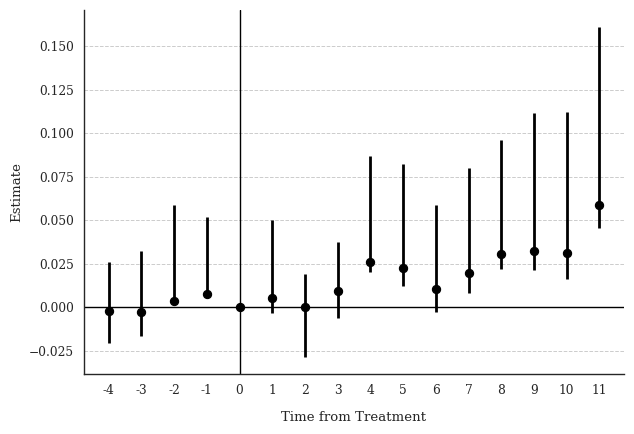

In [ ]:
model = DidHad(kernel="epa")
result = model.fit(
    df=df,
    outcome='emp_growth',
    group='pid',
    time='year',
    treatment='D',
    effects=11,
    placebo=4
)
# Plot and save
fig = model.plot()[0]
fig.savefig('../figures/emp_had_full_python.pdf')

In [ ]:
import os
print(os.getcwd())

/Users/anzony.quisperojas/Documents/GitHub/py_did_had/tests


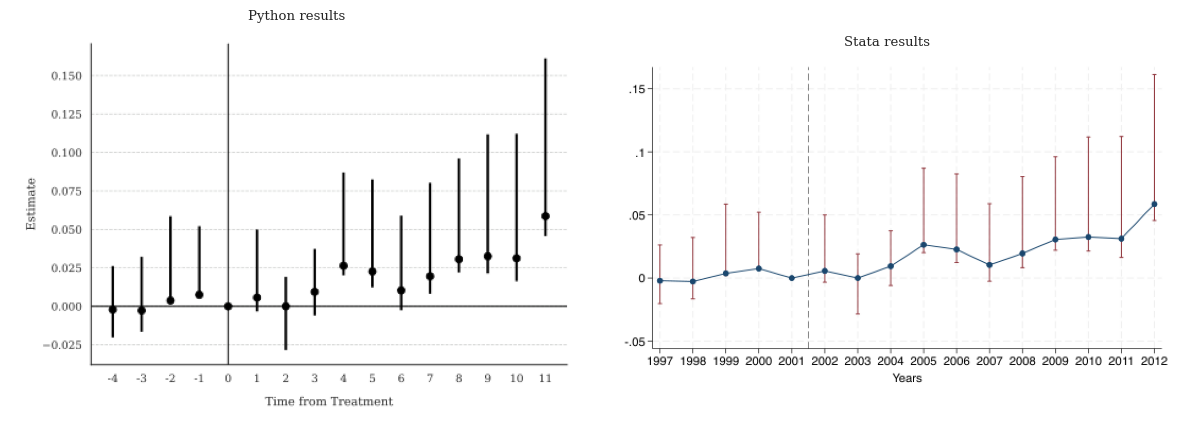

In [ ]:
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

# Open PDFs and convert to images
pdf1 = fitz.open('../figures/emp_had_full_python.pdf')
pdf2 = fitz.open('../figures/emp_had_full_stata.pdf')

img1 = pdf1[0].get_pixmap()
img2 = pdf2[0].get_pixmap()

# Convert to PIL images
from PIL import Image
img1 = Image.frombytes("RGB", [img1.width, img1.height], img1.samples)
img2 = Image.frombytes("RGB", [img2.width, img2.height], img2.samples)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[0].set_title('Python results')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Stata results')
axes[1].axis('off')

plt.tight_layout()
plt.show()

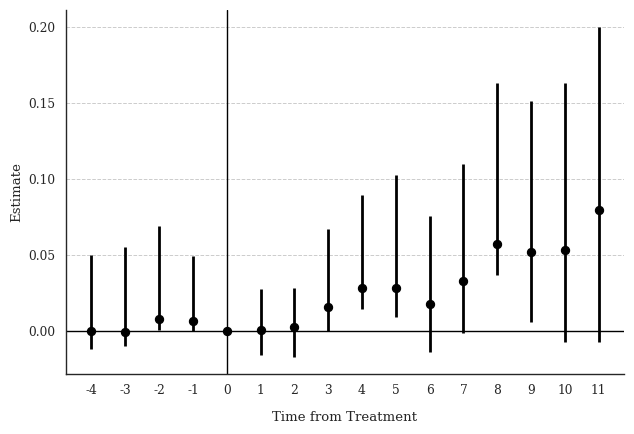

In [ ]:
model = DidHad(kernel="epa")
result = model.fit(
    df=df.query('top_link != 0'),
    outcome='emp_growth',
    group='pid',
    time='year',
    treatment='D',
    effects=11,
    placebo=4
)
# Plot and save
fig = model.plot()[0]
fig.savefig('../figures/emp_had_sample_python.pdf')

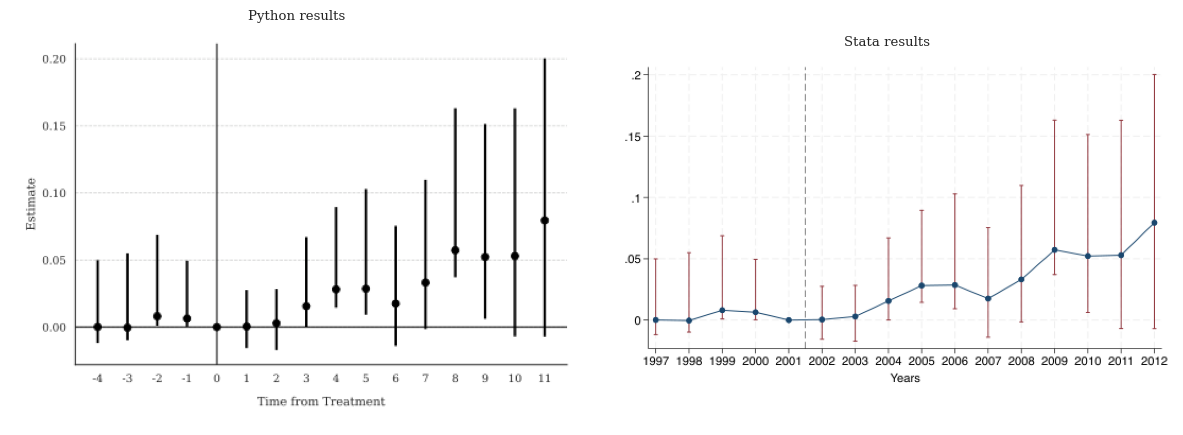

In [ ]:
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

# Open PDFs and convert to images
pdf1 = fitz.open('../figures/emp_had_sample_python.pdf')
pdf2 = fitz.open('../figures/emp_had_sample_stata.pdf')

img1 = pdf1[0].get_pixmap()
img2 = pdf2[0].get_pixmap()

# Convert to PIL images
from PIL import Image
img1 = Image.frombytes("RGB", [img1.width, img1.height], img1.samples)
img2 = Image.frombytes("RGB", [img2.width, img2.height], img2.samples)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[0].set_title('Python results')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Stata results')
axes[1].axis('off')

plt.tight_layout()
plt.show()